## This notebook works on implementing the framework described by schafer

### First let's initiale the sample we are gonna work on

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
T = 1000 # number of time points
n = 44 # number of stocks

In [3]:
#generate data from a multivariate normal distribution with mean 0 and random covariance matrix

def generate_data(T, n):
    # Generate random eigenvalues for the correlation matrix
    eigvals = np.random.uniform(0.5, 1.5, size=n)
    eigvals *= n / eigvals.sum()  # rescale so they sum to n, necessary for correlation matrix

    # Generate random correlation matrix between stocks
    corr = stats.random_correlation.rvs(eigvals)

    # choose realistic volatilities (daily std dev 1–4% -> annualized 16–64% bc np.sqrt(264) = 16.25)
    vols = np.random.uniform(0.01, 0.04, size=n)

    # build covariance matrix Σ = D_vol * Corr * D_vol
    cov = np.outer(vols, vols) * corr
    
    R = np.random.multivariate_normal(mean=np.zeros(n), cov=cov, size=T).T
    return cov, R


In [628]:
import numpy as np
import pandas as pd
import yfinance as yf

def generate_real_market_data(T=1000, n=50, start="2018-01-01"):

    universe = [
        "AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA", "JPM", "V", "JNJ",
        "PG", "BAC", "XOM", "HD", "UNH", "MA", "DIS", "NFLX", "CSCO", "INTC",
        "KO", "PFE", "ADBE", "CMCSA", "WMT", "CVX", "ORCL", "IBM", "CRM", "NKE",
        "MCD", "TXN", "LLY", "ABT", "NEE", "T", "PEP", "AMGN", "QCOM", "LOW",
        "UPS", "HON", "BMY", "SBUX", "CAT", "GE", "MMM", "DHR", "GILD", "SPGI"
    ] # 50 largest stocks by market cap in the US as of 2023

    data = yf.download(universe, start=start, progress=False)["Close"]

    data = data.dropna(axis=1)



    data = data.tail(T+1)

    log_ret = np.log(data / data.shift(1)).dropna()

    tickers_final = log_ret.columns[:n]
    R_df = log_ret[tickers_final]

    cov = R_df.cov()
    R = R_df.values


    return cov, R


In [15]:
cov, R = generate_data(T, n)
cov = np.cov(R)

In [629]:
cov, R = generate_real_market_data(T, n)
R = R.T
cov = np.array(cov)

/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_80192/278503101.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(universe, start=start, progress=False)["Close"]


Perfect the log return follow a normal distribution which is approximately the case 

In [6]:
def make_monotone_pattern(R, rng=None, decreasing=True): # decreasing will be usefull later to use increasing
    n, T = R.shape

    # Step 1 — Generate random "last observed" times
    # The idea is to sample decreasing values from T down to some minimum
    t = np.concatenate([np.random.default_rng().integers(low=T//2.5, high=T+1, size=n-1), [T]])
    t_vec = T - np.sort(t)[::-1]

    # Step 2 — Create mask: asset i observed for columns T-t_i-1, T
    cols = np.arange(T)[None, :]

    mask = cols >= t_vec[:, None]

    # Step 3 — Apply mask
    R_mono = R.copy().astype(float)
    R_mono[~mask] = np.nan

    return R_mono, t_vec, mask


In [7]:
R_hat, t_vec, mask = make_monotone_pattern(R)

### Let's compute $\hat{\Sigma}$

#### We will first calculate the $\phi$

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
def fit_monotone_regressions(R, t):
    n, T = R.shape
    phi_list = []
    for k in range(n):
        t_k = t[k]
        y = R[k,t_k:]
        if k==0:
            beta0 = np.nanmean(R[0, :])
            beta = np.array([])
            resid = y - beta0
            sigma2 = float(resid.T @ resid) / len(resid)
            phi_list.append((beta0, beta, sigma2))
        else:
            X = R[:k,t_k:].T
            reg = LinearRegression(fit_intercept=True) # add the 0 column for intercept
            reg.fit(X, y)

            beta0 = reg.intercept_
            beta = reg.coef_
            resid = y -reg.predict(X)

            sigma2 = (resid.T @ resid) / len(resid) 
            phi_list.append((beta0, beta, sigma2))
    return phi_list


#### Construction of $\mu$ and $\Sigma$ from $\phi$

In [12]:
import numpy as np

def reconstruct_mu_sigma_from_phi(phi_list):

    p = len(phi_list)
    mu = np.zeros(p, dtype=float)
    Sigma = np.zeros((p, p), dtype=float)

    # k = 0
    beta0_1, beta_1, sigma2_1 = phi_list[0]
    mu[0] = beta0_1
    Sigma[0, 0] = sigma2_1 

    #k = 1..p-1
    for k in range(1, p):
        beta0_k, beta_k, sigma2_k = phi_list[k]

        # 1) mean mu_k = beta0_k + beta_k * mu_{1:k}
        mu[k] = beta0_k + beta_k @ mu[:k]

        # 2) blocs of Sigma
        #    S_{11} = Sigma[:k, :k] already known (k excluded in this notation)
        S11 = Sigma[:k, :k]

        #    cross-covariances : Sigma[k, :k] = beta_k * S11
        cross = beta_k @ S11                    # shape: (k,)
        Sigma[k, :k] = cross
        Sigma[:k, k] = cross.T # symetric

        #    variance marginal
        Sigma[k, k] = sigma2_k + cross @ beta_k.T

    return mu, Sigma


In [ ]:
mu_hat, Sigma_hat = reconstruct_mu_sigma_from_phi(fit_monotone_regressions(R_hat, t_vec))

#### Testing

In [638]:
diff = Sigma_hat - cov
print("Max abs diff:", np.max(np.abs(diff)))
print("Mean abs diff:", np.mean(np.abs(diff)))

Max abs diff: 0.00044465465253498346
Mean abs diff: 1.6693277730832064e-05


In [639]:
import numpy as np

fro_abs = np.linalg.norm(diff, ord='fro')
fro_rel = fro_abs / np.linalg.norm(cov, ord='fro')

print(f"Error Frobenius absolute = {fro_abs:.3e}")
print(f"Error Frobenius relative = {fro_rel:.3e}")

Error Frobenius absolute = 1.279e-03
Error Frobenius relative = 1.905e-01


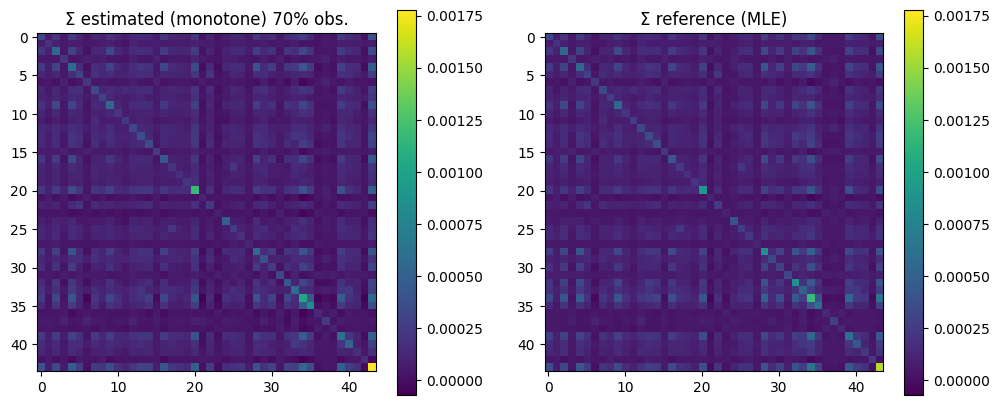

In [646]:
import matplotlib.pyplot as plt

vmin = min(Sigma_hat.min(), cov.min())
vmax = max(Sigma_hat.max(), cov.max())

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(Sigma_hat, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(); plt.title(f'Σ estimated (monotone) {(T-t_vec).sum()/(n*T)*100:.0f}% obs.')

plt.subplot(1,2,2)
plt.imshow(cov, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(); plt.title('Σ reference (MLE)')

plt.savefig('images/comparaison_2_etimator.png')

plt.show()


In [641]:
np.allclose(Sigma_hat, Sigma_hat.T)


True

In [644]:
# table of eigenvalues saved as image
eigenvalues_hat = np.linalg.eigvalsh(Sigma_hat)[::-1]
eigenvalues = np.linalg.eigvalsh(cov)[::-1]


Relative eigenvalue error: 3.670e-02
Top eigenvector cosine similarity: 0.991


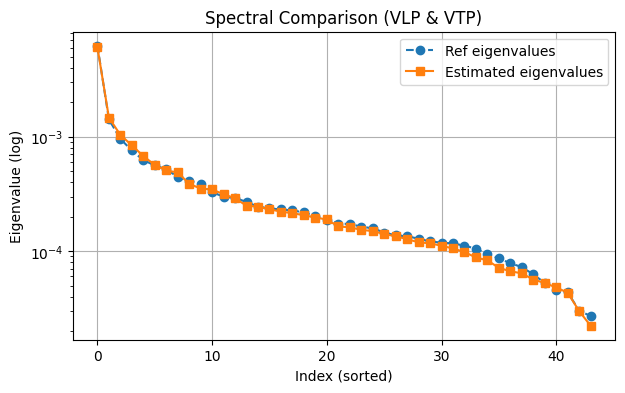

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

eigval_ref, eigvec_ref = np.linalg.eigh(cov)
eigval_hat, eigvec_hat = np.linalg.eigh(Sigma_hat)

idx_ref = np.argsort(eigval_ref)[::-1]
idx_hat = np.argsort(eigval_hat)[::-1]
eigval_ref, eigval_hat = eigval_ref[idx_ref], eigval_hat[idx_hat]
eigvec_ref, eigvec_hat = eigvec_ref[:, idx_ref], eigvec_hat[:, idx_hat]

rel_err_eig = np.linalg.norm(eigval_hat - eigval_ref) / np.linalg.norm(eigval_ref)

cosine_sim = np.abs(np.sum(eigvec_ref[:, 0] * eigvec_hat[:, 0]))

print(f"Relative eigenvalue error: {rel_err_eig:.3e}")
print(f"Top eigenvector cosine similarity: {cosine_sim:.3f}")

plt.figure(figsize=(7,4))
plt.plot(eigval_ref, 'o--', label='Ref eigenvalues')
plt.plot(eigval_hat, 's-', label='Estimated eigenvalues')
plt.yscale('log')
plt.xlabel('Index (sorted)')
plt.ylabel('Eigenvalue (log)')
plt.title('Spectral Comparison (VLP & VTP)')
plt.legend()
plt.grid(True)
plt.show()
